In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
#If using script on terminal
#import tqdm
from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = labels[idx]
        data_point = data.iloc[idx].to_dict()
        return self.transform(new_image), label, image, data_point
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [3]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [4]:
num_pos, num_neg = 40, 40
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'

hdu_list = fits.open(path + 'exp/33.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_pos)
images_pos = hdu_list[1].data[idx,:] 
data_pos = pd.DataFrame(hdu_list[2].data[:][idx])
labels_pos = np.zeros(num_pos, dtype = np.int64)
print(len(hdu_list[1].data))

hdu_list = fits.open(path + 'negative_cases.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_neg)
images_neg = hdu_list[1].data[idx,:] 
labels_neg = np.ones(num_neg, dtype = np.int64)
#Data for negatives, all null
num_columns = len(data_pos.columns)
data_neg = np.full((num_neg, num_columns-1), 0)
data_neg = pd.DataFrame(data_neg, columns=['zl/z1', 'm', 'iso', 'E', 'Magni 1'])
last_column = ['NEG']*num_neg
data_neg['ID'] = last_column

images = np.concatenate((images_pos, images_neg)).astype(np.float32)
data = pd.concat([data_pos, data_neg], axis=0).reset_index(drop=True)
labels = np.concatenate((labels_pos,labels_neg), dtype = np.int64)

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = ImageDataset(images, data, labels, transform=transform)

5085


In [5]:
train_dataset, test_dataset = make_train_test_datasets(images, data, labels, test_size=0.2, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 64, len test dataset: 16


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=20, num_workers=0, shuffle=True)

In [7]:
model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [8]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i, (data, target, sample_img, sample_data) in tqdm(enumerate(train_loader)):
        for i, (data, target, sample_img, sample_data) in enumerate(tqdm(train_loader)):


            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)

            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            #accuracy = (output.argmax(dim=1) == target).float().mean()
            print(target)
            print(output.argmax(dim=1))
            accuracy = sum(output.argmax(dim=1) == target)
            print(accuracy)
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader.dataset)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target, sample_img, sample_data in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                #accuracy = (output.argmax(dim=1) == target).float().mean()
                print(target)
                print(output.argmax(dim=1))
                accuracy = sum(output.argmax(dim=1) == target)
                print(accuracy)
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader.dataset)

In [9]:
model = ViTBase16(n_classes=2, pretrained=True)

# Start training processes
device = torch.device("cuda")

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [10]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc
    """
    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }"""

In [11]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    #plt.savefig('Performance.png', bbox_inches='tight')
    plt.show(block=True)

In [12]:
print(len(train_dataset), len(test_dataset))
name_model = 'other.pt'
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, 1, device, criterion, optimizer, train_loader, test_loader)))

64 16
EPOCH 1 - TRAINING...


  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor(7)
tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(8)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(16)
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])
tensor(3)

	[TRAIN] EPOCH 1 - LOSS: 0.058268092572689056, ACCURACY: 0.53125

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(16)
	[VALID] LOSS: 0.02281973324716091, ACCURACY: 1.0



In [13]:
print('Maximum memory usage: %s' % max(mem_usage))

Maximum memory usage: 3242.58984375


In [14]:
name = 'other.pt'#'model.pt'#'other.pt' 
model_test = torch.load(name)
print('Maximum validation accuracy: {:.2f}%'.format(100*model_test.validation_acc[-1].item()))

Maximum validation accuracy: 100.00%


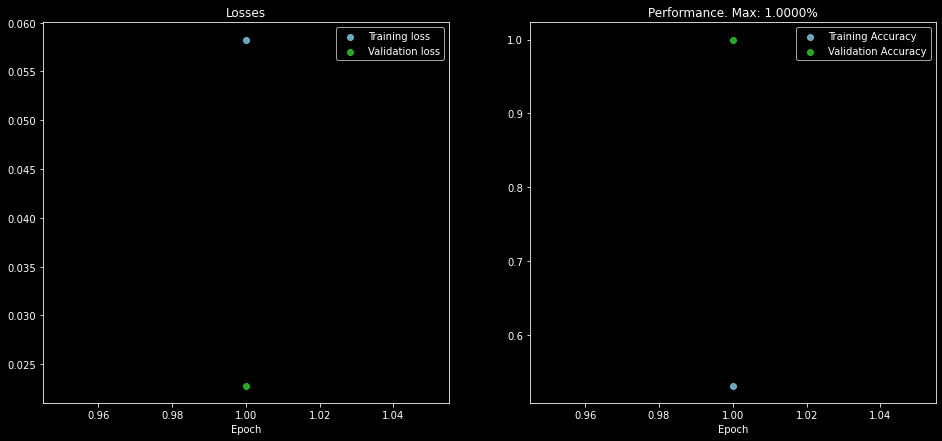

In [15]:
plot_performance(model_test)

In [16]:
new_test_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, num_workers=0, shuffle=True)

In [17]:
model = model_test
right_pos_img, wrong_pos_img = np.zeros((1,3,46,46)), np.zeros((1,3,46,46))
right_neg_img, wrong_neg_img = np.zeros((1,3,46,46)), np.zeros((1,3,46,46))
columns = ['zl/z1', 'm', 'iso', 'E', 'Magni 1', 'ID', 'Prob']
prob_list = []
right_pos, wrong_pos = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)
right_neg, wrong_neg = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)

for i_batch, (sample_image, sample_label, sample_img, sample_data) in enumerate(tqdm(new_test_loader)):
    #if(i_batch <= 50): continue
    output = model(sample_image)
    predicted = output.argmax(dim=1)
    my_df = pd.DataFrame.from_dict(sample_data)
    
    prob = nn.Softmax(dim=1)(output)
    prob = prob[:,0].detach().numpy()[0]
    prob_list.append(prob)
    
    if(sample_label.item() == 0):
        if(predicted.item() == 0):
            right_pos_img = np.append(right_pos_img, [np.array(sample_img[0])], axis = 0)
            new_df = pd.DataFrame.from_dict(sample_data)
            new_df['Prob'] = prob
            print(new_df)
            right_pos = right_pos.append(pd.DataFrame.from_dict(sample_data), ignore_index=True)
        elif(predicted.item() == 1):
            wrong_pos_img = np.append(wrong_pos_img, [np.array(sample_img[0])], axis = 0)
            wrong_pos = wrong_pos.append(pd.DataFrame.from_dict(sample_data), ignore_index=True)
    elif(sample_label.item() == 1):
        if(predicted.item() == 1): right_neg_img = np.append(right_neg_img, [np.array(sample_img[0])], axis = 0)
        else: wrong_neg_img = np.append(wrong_neg_img, [np.array(sample_img[0])], axis = 0)
    
    
right_pos_img = np.delete(right_pos_img, 0, axis = 0)
wrong_pos_img = np.delete(wrong_pos_img, 0, axis = 0)
right_neg_img = np.delete(right_neg_img, 0, axis = 0)
wrong_neg_img = np.delete(wrong_neg_img, 0, axis = 0)

  0%|          | 0/64 [00:00<?, ?it/s]

      zl/z1          m      iso         E   Magni 1               ID      Prob
0  0.670784  22.464902  0.47308  1.546614  5.387487  POS_137197788_0  0.618797
      zl/z1          m       iso         E   Magni 1               ID  \
0  0.435967  21.736998  0.613872  2.467451  7.675117  POS_210062928_0   

       Prob  
0  0.636169  
      zl/z1          m       iso         E   Magni 1               ID  \
0  0.559723  22.592647  1.011002  2.593149  3.078988  POS_198471131_0   

       Prob  
0  0.652838  
      zl/z1          m       iso         E   Magni 1               ID  \
0  0.536323  23.148573  0.562516  1.613772  5.339042  POS_256499666_0   

       Prob  
0  0.653019  
      zl/z1          m       iso         E   Magni 1              ID     Prob
0  0.472761  20.687758  0.449333  2.277236  12.84066  POS_94357768_0  0.77341
      zl/z1          m       iso         E   Magni 1              ID      Prob
0  0.477464  23.883415  0.764629  1.868133  3.071517  POS_62993321_0  0.668244
   

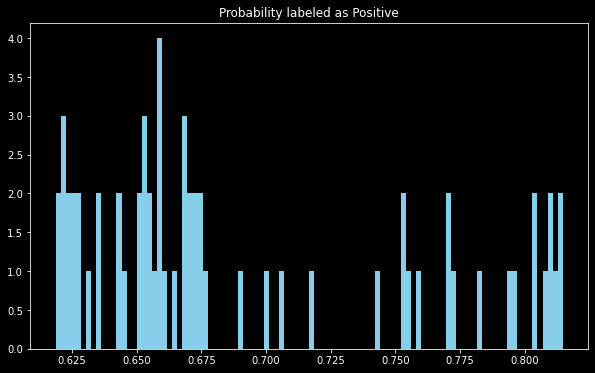

In [18]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Positive')
plt.hist(prob_list, 100, color = "skyblue")
#plt.savefig(path_im + '/' + 'Prob_Pos Distribution.png', bbox_inches='tight')
plt.show()

In [19]:
print(right_pos_img.shape)
print(wrong_pos_img.shape)
print(right_neg_img.shape)
print(wrong_neg_img.shape)

(40, 3, 46, 46)
(0, 3, 46, 46)
(0, 3, 46, 46)
(24, 3, 46, 46)


In [20]:
right_pos.head()

,zl/z1,m,iso,E,Magni 1,ID,Prob
0,0.670784,22.464902,0.473080,1.546614,5.387487,POS_137197788_0,NaN
1,0.435967,21.736998,0.613872,2.467451,7.675117,POS_210062928_0,NaN
2,0.559723,22.592647,1.011002,2.593149,3.078988,POS_198471131_0,NaN
3,0.536323,23.148573,0.562516,1.613772,5.339042,POS_256499666_0,NaN
4,0.472761,20.687758,0.449333,2.277236,12.840660,POS_94357768_0,NaN


In [21]:
def make_plot_all(objects, title):
    print(title)
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show() 

Wrong negatives


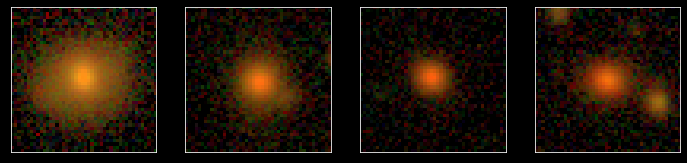

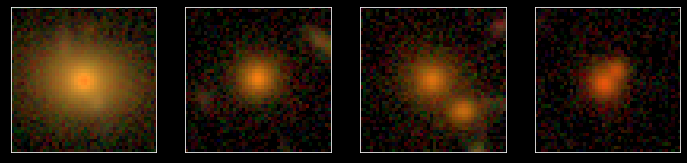

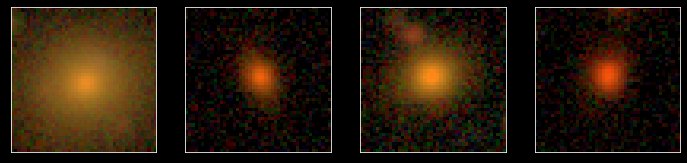

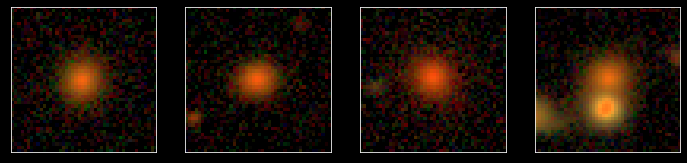

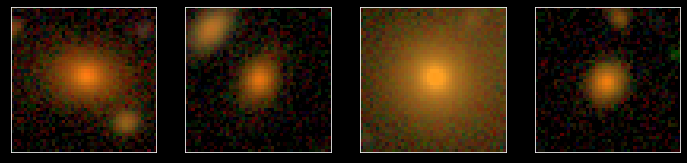

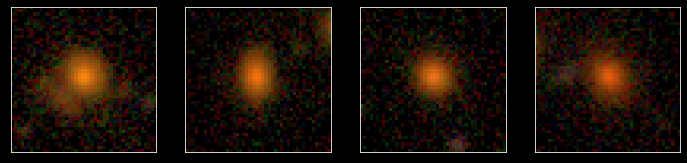

In [22]:
make_plot_all(wrong_neg_img, 'Wrong negatives')

In [23]:
make_plot_all(wrong_pos_img, 'Wrong positives')

Wrong positives


Right positives


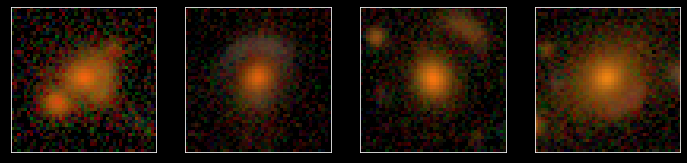

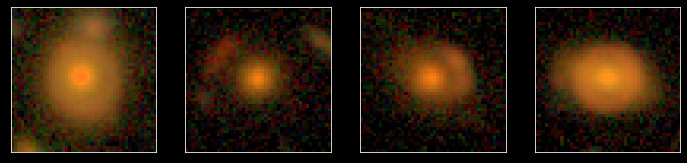

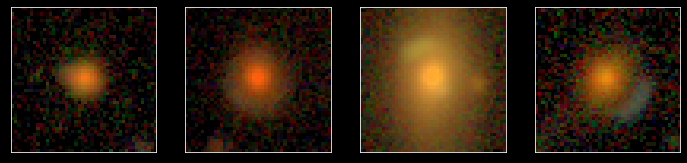

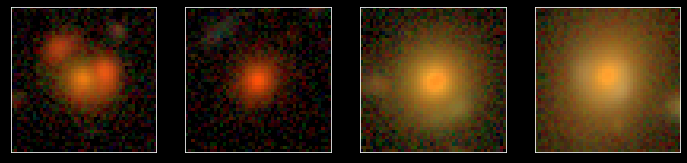

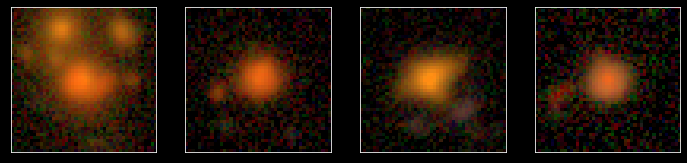

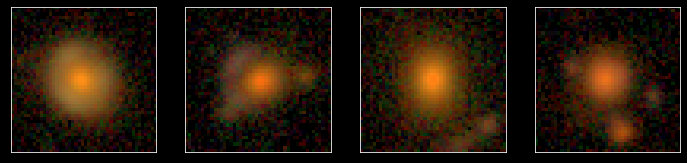

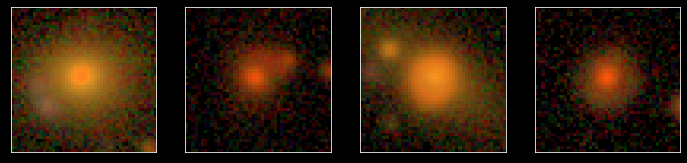

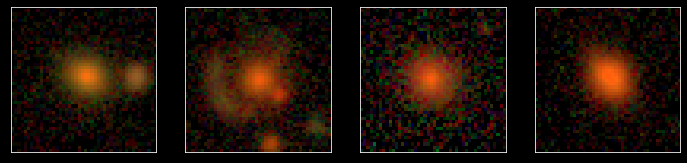

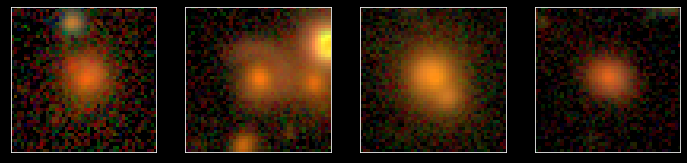

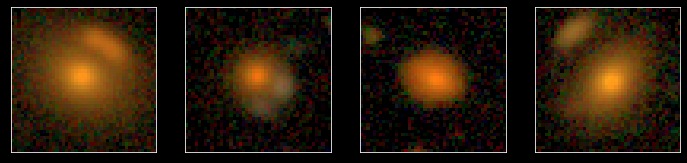

In [24]:
make_plot_all(right_pos_img, 'Right positives')

In [25]:
make_plot_all(right_neg_img, 'Right negatives')

Right negatives
